In [2]:
# Install Dependencies
!pip install -q transformers datasets torch torchvision ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 976.9/976.9 kB 17.0 MB/s eta 0:00:0000:01


In [3]:
import cv2
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
from ultralytics import YOLO
from transformers import AutoImageProcessor, AutoModelForImageClassification
from datasets import Dataset
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("manjilkarki/deepfake-and-real-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/deepfake-and-real-images


In [5]:
# ============================================
# 1. Set Dataset Paths (Edit here if needed)
# ============================================
train_real_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Train/Real'
train_fake_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Train/Fake'

val_real_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Validation/Real'
val_fake_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Validation/Fake'

test_real_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Test/Real'
test_fake_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Test/Fake'

In [6]:
# import os

# # Set your directory path
# train_real_directory = train_real_dir
# test_directory = test_real_dir
# val_directory = val_real_dir

# train_directory = train_fake_dir
# test_directory = test_fake_dir
# val_directory = val_fake_dir

# Define image extensions you want to count
image_extensions = ('.jpg')

def count_images(directory):
    return len([file for file in os.listdir(directory) if file.lower().endswith(image_extensions)])

# Count & Print
print(f"Total Train Real Images: {count_images(train_real_dir)}")
print(f"Total Train Fake Images: {count_images(train_fake_dir)}")
print(f"Total Validation Real Images: {count_images(val_real_dir)}")
print(f"Total Validation Fake Images: {count_images(val_fake_dir)}")
print(f"Total Test Real Images: {count_images(test_real_dir)}")
print(f"Total Test Fake Images: {count_images(test_fake_dir)}")


Total Train Real Images: 70001
Total Train Fake Images: 70001
Total Validation Real Images: 19787
Total Validation Fake Images: 19641
Total Test Real Images: 5413
Total Test Fake Images: 5492


In [7]:
import shutil

# Remove old directories if exist
shutil.rmtree('/kaggle/working/haar_faces', ignore_errors=True)
shutil.rmtree('/kaggle/working/yolo_faces', ignore_errors=True)

# Now recreate clean structure
splits = ['Train', 'Test', 'Validation']
classes = ['real', 'fake']

for split in splits:
    for cls in classes:
        os.makedirs(f"/kaggle/working/haar_faces/{split}/{cls}", exist_ok=True)
        os.makedirs(f"/kaggle/working/yolo_faces/{split}/{cls}", exist_ok=True)

print("All directories cleaned & recreated.")


All directories cleaned & recreated.


In [8]:
# ============================================
# 3. Haar Cascade Face Cropping
# ============================================
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def haar_crop(image_path, save_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for i, (x, y, w, h) in enumerate(faces):
        face = img[y:y+h, x:x+w]
        if face.size != 0:
            cv2.imwrite(save_path, face)


In [9]:
from tqdm import tqdm
import os
import random

# Your existing haar_crop function is assumed to be defined

# Define directories
splits = ['Train', 'Test', 'Validation']
classes = ['real', 'fake']

# Input Directories
input_base_dir = '/kaggle/input/deepfake-and-real-images/Dataset'  # Change to your dataset root

# Output Haar directory
haar_dir = '/kaggle/working/haar_faces'

# Process all
max_samples = 2000  # Limit per category

for split in splits:
    for cls in classes:
        input_dir = f"{input_base_dir}/{split}/{cls.capitalize()}"  # Capitalized if your folder names are like Real, Fake
        output_dir = f"{haar_dir}/{split}/{cls}"
        os.makedirs(output_dir, exist_ok=True)

        img_list = os.listdir(input_dir)
        random.shuffle(img_list)  # Shuffle to get a random subset
        img_list = img_list[:max_samples]  # Take only 5000 samples

        print(f"Processing Haar Crop - {split} / {cls} ({len(img_list)} samples)")
        for img_name in tqdm(img_list, desc=f"Haar {split}-{cls}"):
            input_path = os.path.join(input_dir, img_name)
            output_path = os.path.join(output_dir, img_name)
            haar_crop(input_path, output_path)

print("✅ Haar Cropping completed for Train, Test, Validation.")


Processing Haar Crop - Train / real (2000 samples)


Haar Train-real: 100%|██████████| 2000/2000 [00:55<00:00, 35.77it/s]


Processing Haar Crop - Train / fake (2000 samples)


Haar Train-fake: 100%|██████████| 2000/2000 [00:55<00:00, 36.35it/s]


Processing Haar Crop - Test / real (2000 samples)


Haar Test-real: 100%|██████████| 2000/2000 [00:56<00:00, 35.14it/s]


Processing Haar Crop - Test / fake (2000 samples)


Haar Test-fake: 100%|██████████| 2000/2000 [00:57<00:00, 34.68it/s]


Processing Haar Crop - Validation / real (2000 samples)


Haar Validation-real: 100%|██████████| 2000/2000 [00:55<00:00, 35.72it/s]


Processing Haar Crop - Validation / fake (2000 samples)


Haar Validation-fake: 100%|██████████| 2000/2000 [00:57<00:00, 34.58it/s]

✅ Haar Cropping completed for Train, Test, Validation.


In [10]:
import os

def show_folder_tree(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")

# Example: Show Dataset Directory Structure
show_folder_tree('/kaggle/input/deepfake-and-real-images')
show_folder_tree('/kaggle/working')


deepfake-and-real-images/
    Dataset/
        Validation/
            Fake/
            Real/
working/
    yolo_faces/
        Validation/
            real/
            fake/
        Train/
            real/
            fake/
        Test/
            real/
            fake/
    haar_faces/
        Validation/
            real/
            fake/
        Train/
            real/
            fake/
        Test/
            real/
            fake/
    .virtual_documents/


In [11]:
# import shutil

# shutil.make_archive('/kaggle/working/haar_faces', 'zip', '/kaggle/working/haar_faces')


In [12]:
# from IPython.display import FileLink

# FileLink('/kaggle/working/haar_faces.zip')


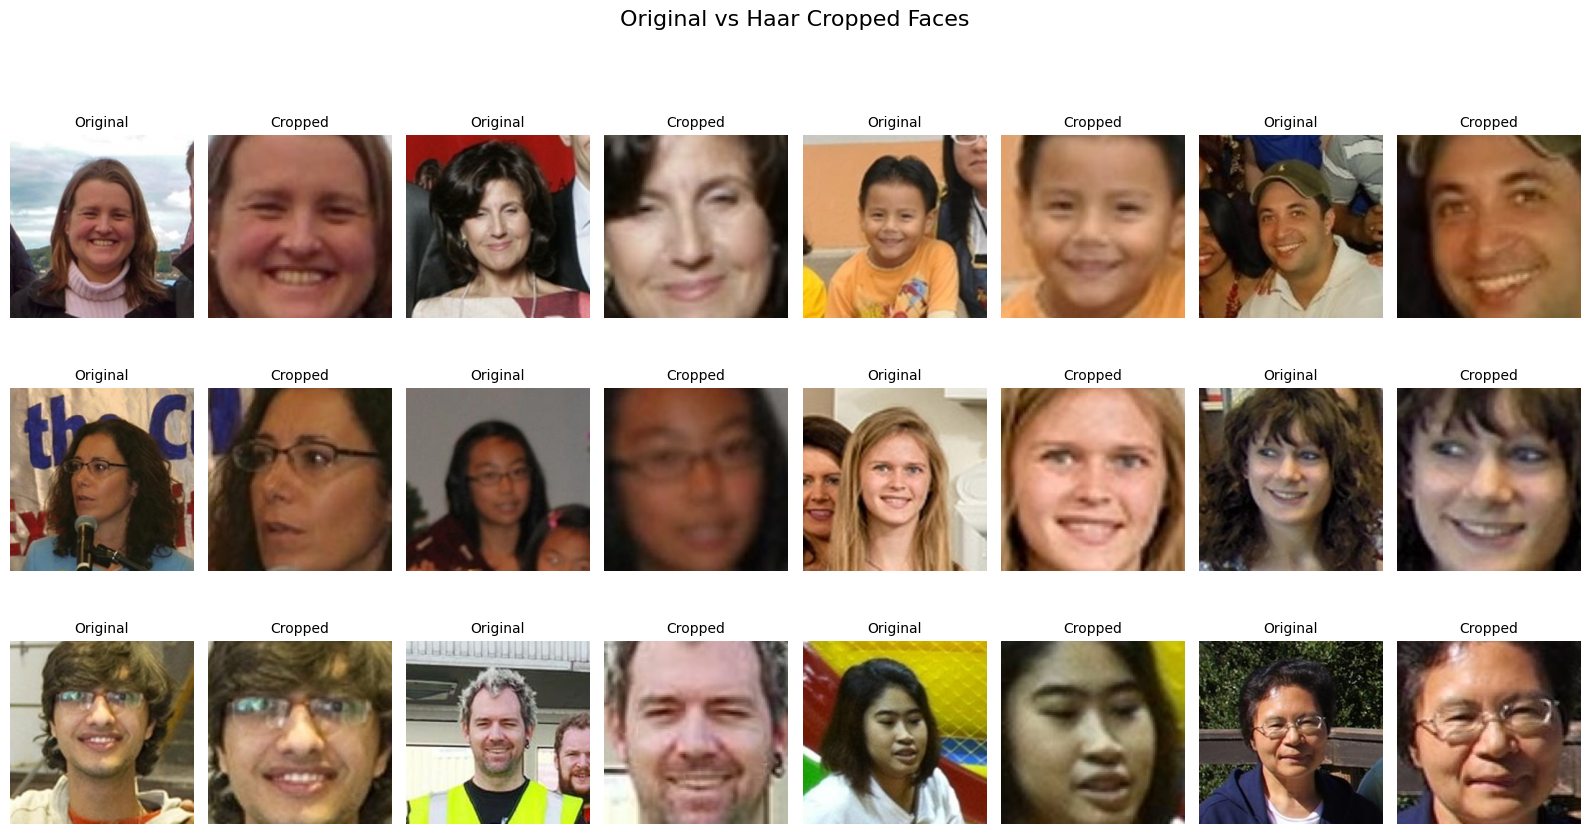

✅ Displayed 12 original-cropped pairs.


In [13]:
import matplotlib.pyplot as plt
import cv2
import os

rows, cols = 3, 4
max_images = rows * cols

image_files = [img for img in os.listdir(train_real_dir) if img.lower().endswith(('.jpg', '.png'))]

original_images = []
cropped_images = []

for img_name in image_files:
    original_path = os.path.join(train_real_dir, img_name)
    cropped_path = f"{haar_dir}/Train/real/{img_name}"

    original_img = cv2.imread(original_path)
    cropped_img = cv2.imread(cropped_path)

    if cropped_img is None:
        continue

    original = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    cropped = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)

    original_images.append(original)
    cropped_images.append(cropped)

    if len(original_images) == max_images:
        break

# Now plot only collected images
fig, axes = plt.subplots(rows, cols * 2, figsize=(16, 9))
plt.suptitle('Original vs Haar Cropped Faces', fontsize=16)

for idx in range(len(original_images)):
    row = idx // cols
    col = (idx % cols) * 2

    axes[row, col].imshow(original_images[idx])
    axes[row, col].set_title('Original', fontsize=10)
    axes[row, col].axis('off')

    axes[row, col + 1].imshow(cropped_images[idx])
    axes[row, col + 1].set_title('Cropped', fontsize=10)
    axes[row, col + 1].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

print(f"✅ Displayed {len(original_images)} original-cropped pairs.")


In [14]:
# ============================================
# 4. YOLO Face Detection (Optional Refinement)
# ============================================
# yolo_model = YOLO('yolov8n.pt')

# def yolo_crop(image_path, save_path):
#     results = yolo_model(image_path, verbose=False)
#     for r in results:
#         for box in r.boxes:
#             x1, y1, x2, y2 = map(int, box.xyxy[0])
#             img = cv2.imread(image_path)
#             face = img[y1:y2, x1:x2]
#             if face.size != 0:
#                 cv2.imwrite(save_path, face)

In [15]:
from tqdm import tqdm
import os

# ===============================
#  YOLO Crop for Train, Test, Validation
# ===============================

# Define your directories
# sets = ['Train', 'Test', 'Validation']
# classes = ['real', 'fake']

# for dataset in sets:
#     for label in classes:
#         input_dir = f"{haar_dir}/{dataset}/{label}"
#         output_dir = f"{yolo_dir}/{dataset}/{label}"

#         # Create output directory if not exists
#         os.makedirs(output_dir, exist_ok=True)

#         print(f"Processing YOLO Crop: {dataset}/{label}")
#         for img_name in tqdm(os.listdir(input_dir), desc=f"YOLO {dataset} {label}"):
#             input_path = os.path.join(input_dir, img_name)
#             output_path = os.path.join(output_dir, img_name)
#             yolo_crop(input_path, output_path)


In [16]:
# import os
# import cv2
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# rows, cols = 3, 4  # Total images = rows * cols
# count = 0

# fig, axes = plt.subplots(rows, cols * 3, figsize=(18, 10))  # *3 for original + cropped + yolo
# plt.suptitle('Original vs Haar Cropped vs YOLO Detected Faces', fontsize=16)

# for img_name in tqdm(os.listdir(fake_dir), desc="Grid Haar Real"):
#     original_path = os.path.join(fake_dir, img_name)
#     cropped_path = os.path.join(haar_dir, 'fake', img_name)
#     yolo_path = os.path.join(yolo_dir, 'fake', img_name)

#     # Read images
#     original_img = cv2.imread(original_path)
#     cropped_img = cv2.imread(cropped_path)
#     yolo_img = cv2.imread(yolo_path)

#     # Skip if any image not found
#     if original_img is None or cropped_img is None or yolo_img is None:
#         continue

#     # Convert to RGB
#     original = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
#     cropped = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
#     yolo_detected = cv2.cvtColor(yolo_img, cv2.COLOR_BGR2RGB)

#     row = count // cols
#     col = (count % cols) * 3  # *3 for three images per sample

#     axes[row, col].imshow(original)
#     axes[row, col].set_title('Original', fontsize=9)
#     axes[row, col].axis('off')

#     axes[row, col + 1].imshow(cropped)
#     axes[row, col + 1].set_title('Haar Cropped', fontsize=9)
#     axes[row, col + 1].axis('off')

#     axes[row, col + 2].imshow(yolo_detected)
#     axes[row, col + 2].set_title('YOLO Detected', fontsize=9)
#     axes[row, col + 2].axis('off')

#     count += 1
#     if count == rows * cols:
#         break

# plt.tight_layout()
# plt.subplots_adjust(top=0.92)
# plt.show()


In [17]:
import numpy as np

In [18]:
import os
import torch
import numpy as np
from PIL import Image
from datasets import Dataset, DatasetDict
from transformers import AutoImageProcessor, AutoModelForImageClassification
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Define Haar dataset directory
haar_dir = "/kaggle/working/haar_faces"

# Dataset splits
splits = ['Train', 'Test', 'Validation']
data_splits = {}

# Process each split separately
for split in splits:
    image_paths = []
    labels = []

    for label, folder in enumerate(['real', 'fake']):
        folder_path = os.path.join(haar_dir, split, folder)
        for img_name in os.listdir(folder_path):
            image_paths.append(os.path.join(folder_path, img_name))
            labels.append(label)

    data_splits[split.lower()] = Dataset.from_dict({'image': image_paths, 'label': labels})

# Create DatasetDict
dataset = DatasetDict({
    "train": data_splits["train"],
    "test": data_splits["test"],
    "validation": data_splits["validation"]
})

print("✅ Dataset prepared successfully!")

# Load ViT Model and Processor
checkpoint = "google/vit-base-patch16-224-in21k"
processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForImageClassification.from_pretrained(checkpoint, num_labels=2)

# Define Image Transform Function
def transform(example):
    # Load image from path
    img = Image.open(example["image"]).convert("RGB")
    
    # Process image using ViT processor
    example["pixel_values"] = processor(img, return_tensors="pt")["pixel_values"].squeeze(0)
    
    return example

# Apply Transformations to the Dataset
dataset = dataset.map(transform)

# Define Data Collation Function
def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    labels = torch.tensor([example["label"] for example in batch])
    return {"pixel_values": pixel_values, "labels": labels}

# Create DataLoaders
train_dataloader = DataLoader(dataset["train"], batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(dataset["test"], batch_size=32, shuffle=False, collate_fn=collate_fn)
val_dataloader = DataLoader(dataset["validation"], batch_size=32, shuffle=False, collate_fn=collate_fn)

print("✅ DataLoader ready!")


✅ Dataset prepared successfully!


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2929 [00:00<?, ? examples/s]

Map:   0%|          | 0/2654 [00:00<?, ? examples/s]

Map:   0%|          | 0/2812 [00:00<?, ? examples/s]

✅ DataLoader ready!


In [22]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model.to(device)  # Move model to GPU


Using device: cuda


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [24]:
import transformers
transformers.logging.set_verbosity_info()  # Enable logging

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,  # Reduce to avoid OOM
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    fp16=True,  # Enable mixed precision
    logging_steps=10,  # Log progress every 10 steps
    report_to="none",  # Prevent unnecessary WandB logging
)



trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=processor,
)

model.to("cuda")
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
<ipython-input-24-f7caef6a23a4>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using auto half precision backend
The following columns in the training set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: image. If image are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 2,929
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Training with DataParallel so batch size has been adjusted to: 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumula

Epoch,Training Loss,Validation Loss
1,0.093600,0.460072
2,0.119000,0.446000
3,0.033000,0.536857
4,0.048600,0.651620
5,0.175100,0.647756


The following columns in the evaluation set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: image. If image are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2812
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-184
Configuration saved in ./results/checkpoint-184/config.json
Model weights saved in ./results/checkpoint-184/model.safetensors
Image processor saved in ./results/checkpoint-184/preprocessor_config.json
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
The following columns in the evaluation set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: image. If image are not expected by `ViTForImageClassifi

TrainOutput(global_step=920, training_loss=0.11240510057035388, metrics={'train_runtime': 2789.0582, 'train_samples_per_second': 5.251, 'train_steps_per_second': 0.33, 'total_flos': 1.1348701879056998e+18, 'train_loss': 0.11240510057035388, 'epoch': 5.0})

In [25]:
#Testing and Evaluation 
metrics = trainer.evaluate(dataset['test'])
print(metrics)


The following columns in the evaluation set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: image. If image are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2654
  Batch size = 16
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 1.2058275938034058, 'eval_runtime': 236.0016, 'eval_samples_per_second': 11.246, 'eval_steps_per_second': 0.703, 'epoch': 5.0}


The following columns in the test set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: image. If image are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 2654
  Batch size = 16
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


✅ Test Accuracy: 0.8602

🔹 Classification Report:
               precision    recall  f1-score   support

        real       0.86      0.87      0.87      1371
        fake       0.86      0.85      0.85      1283

    accuracy                           0.86      2654
   macro avg       0.86      0.86      0.86      2654
weighted avg       0.86      0.86      0.86      2654



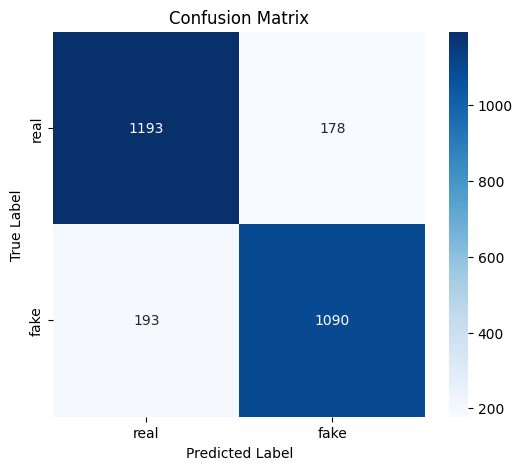

In [26]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions from fine-tuned model
predictions = trainer.predict(dataset["test"])

# Convert logits to class labels
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Compute Accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"✅ Test Accuracy: {accuracy:.4f}")

# Generate Classification Report
class_report = classification_report(true_labels, pred_labels, target_names=["real", "fake"])
print("\n🔹 Classification Report:\n", class_report)

# Compute Confusion Matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["real", "fake"], yticklabels=["real", "fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [27]:
import torch

# Save the model and tokenizer
trainer.save_model("fine_tuned_model")  # Saves model & processor
processor.save_pretrained("fine_tuned_model")

# Save training arguments separately
torch.save(training_args, "training_args.pkl")

print("✅ Trainer components saved successfully!")


Saving model checkpoint to fine_tuned_model
Configuration saved in fine_tuned_model/config.json
Model weights saved in fine_tuned_model/model.safetensors
Image processor saved in fine_tuned_model/preprocessor_config.json
Image processor saved in fine_tuned_model/preprocessor_config.json


✅ Trainer components saved successfully!


In [28]:
import os
print(os.listdir("/kaggle/working/fine_tuned_model"))


['preprocessor_config.json', 'model.safetensors', 'config.json', 'training_args.bin']


In [29]:
from shutil import make_archive
make_archive("/kaggle/working/fine_tuned_model", 'zip', "fine_tuned_model")


'/kaggle/working/fine_tuned_model.zip'